# Importing libraries

In [35]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.layers.pooling import GlobalAveragePooling2D
import numpy as np
import seaborn as sns
import os

from tensorflow.keras import Model,layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

# resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Path

In [36]:
train_dir = './kaggle/input/water-bottle-dataset'
os.path.exists(train_dir)

True

# Callback

In [37]:
from keras.callbacks import EarlyStopping
Callback = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Data Augmentation

In [38]:
# augmentation train only
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   validation_split=0.15,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest'
                                  )

validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split=0.15)

# HyperParamater

In [39]:

HYP = dict(
        seed = 77,
        img_size = (225,225)
        )

# Data Creation

In [40]:
# flow_from_directory
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                            target_size=HYP['img_size'],
                                                            shuffle=True, 
                                                            seed=HYP['seed'],
                                                            class_mode='categorical',
                                                            subset="training")

validation_generator = validation_datagen.flow_from_directory(train_dir,
                                                                target_size=HYP['img_size'],
                                                                shuffle=False, 
                                                                seed=HYP['seed'],
                                                                class_mode='categorical', 
                                                                subset="validation")

Found 415 images belonging to 3 classes.
Found 71 images belonging to 3 classes.


# Create model 
・Fine-tuning<br>
・L1 regularization is a technique to limit model complexity to prevent overfitting.

In [41]:
# load the pre-trained ResNet50 model
base_model = InceptionV3(
                        include_top = False,
                        weights = "imagenet",
                        input_shape = None
)

In [42]:
# New Construction of Fully Connected Layer
from keras import regularizers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu',kernel_regularizer= regularizers.l1(0.001))(x)
predictions = Dense(3, activation='softmax')(x)

In [46]:
from keras import regularizers

# network definition
model = Model(inputs = base_model.input, outputs = predictions)

# Train layer 250 and above
for layer in model.layers[:249]:
    layer.trainable = False

    # Batch Normalization improves the generalization performance of the model by updating parameters during training.
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True

for layer in model.layers[249:]:
    layer.trainable = True

# After setting layer.trainable, be sure to compile.
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)



In [47]:
fit_history = model.fit(
                        train_generator,
                        validation_data=validation_generator,
                        callbacks=Callback,
                        epochs=15,
                        verbose=1
                        )

Epoch 1/15
 4/13 [========>.....................] - ETA: 4s - loss: 26.2262 - accuracy: 0.5591

c:\Users\taka-\anaconda3\envs\tensorflow-new\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


13/13 [==============================] - 18s 818ms/step - loss: 23.6650 - accuracy: 0.6747 - val_loss: 29.8512 - val_accuracy: 0.6901
Epoch 2/15
13/13 [==============================] - 9s 631ms/step - loss: 16.9794 - accuracy: 0.8289 - val_loss: 14.6349 - val_accuracy: 0.8169
Epoch 3/15
13/13 [==============================] - 8s 641ms/step - loss: 11.2044 - accuracy: 0.9084 - val_loss: 9.6315 - val_accuracy: 0.8310
Epoch 4/15
13/13 [==============================] - 8s 639ms/step - loss: 6.9366 - accuracy: 0.9229 - val_loss: 5.9613 - val_accuracy: 0.8451
Epoch 5/15
13/13 [==============================] - 8s 639ms/step - loss: 4.2778 - accuracy: 0.9349 - val_loss: 3.2762 - val_accuracy: 0.9155
Epoch 6/15
13/13 [==============================] - 9s 685ms/step - loss: 2.6111 - accuracy: 0.9590 - val_loss: 1.9832 - val_accuracy: 0.9718
Epoch 7/15
13/13 [==============================] - 11s 845ms/step - loss: 1.6509 - accuracy: 0.9663 - val_loss: 1.2902 - val_accuracy: 0.9718
Epoch 8/15

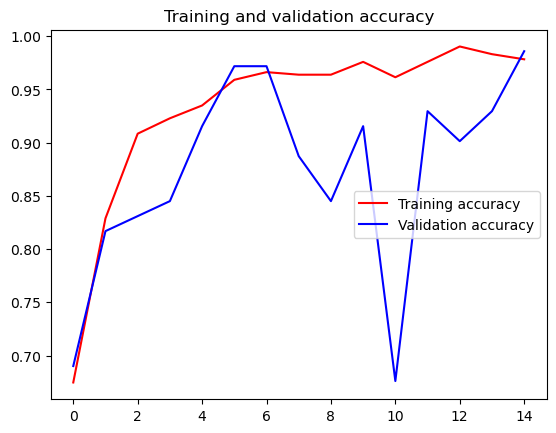

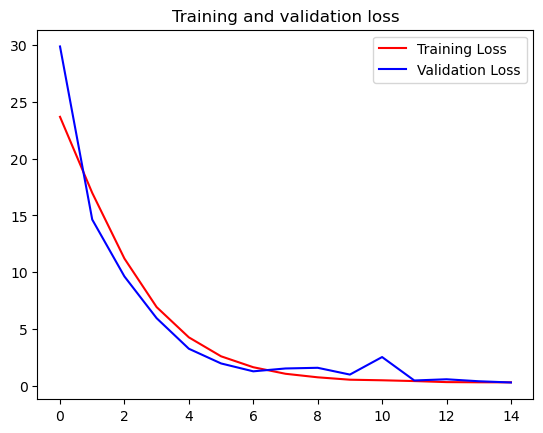

In [48]:
acc = fit_history.history['accuracy']
val_acc = fit_history.history['val_accuracy']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

In [49]:
scores = model.evaluate(validation_generator)

3/3 [==============================] - 1s 136ms/step - loss: 0.3097 - accuracy: 0.9859


# Confusion matrix

3/3 [==============================] - 3s 307ms/step


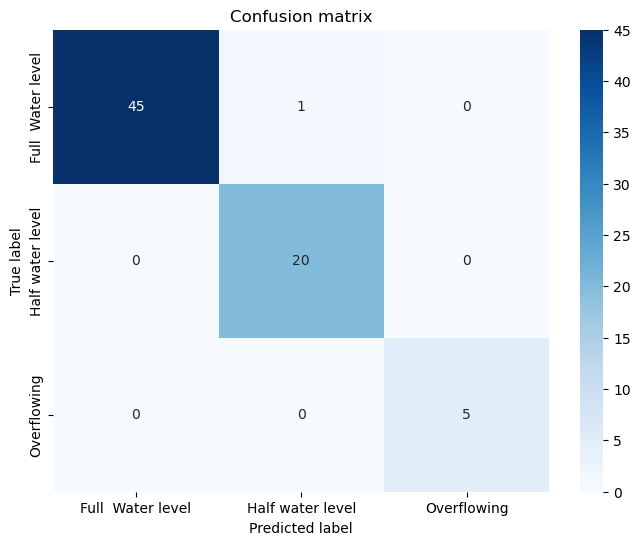

In [50]:
classes = train_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(validation_generator), axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Save model

In [51]:
model.save('water_bottle_inceptionV3_fine-tuning')

INFO:tensorflow:Assets written to: water_bottle_inceptionV3_fine-tuning\assets


INFO:tensorflow:Assets written to: water_bottle_inceptionV3_fine-tuning\assets


#### I used inceptionV3 to do some fine-tuning. As a result, high accuracy was obtained.
